In [1]:
import numpy as np
import pandas as pd
import plotly.express as px
import seaborn as sns
import matplotlib.pyplot as plt

In [125]:
tipo = "Erdos_MDH_socialnetworks"
subfijo = "_EMS"

In [126]:
FastCover = pd.read_csv("FastCover/results/scalefree_MDH_socialnetworks/FastCoverResults_scalefree.txt", header = None)
#FastCover = pd.read_csv("FastCover/results/paper/FastCoverResults_MDH_erdos.txt", header = None)
FastCover.columns = ["graph", "target_size","t_mean","n"]
FastCover["model"] = "GRAT"
FastCover = FastCover[["graph", "model","target_size", "n", "t_mean"]]
FastCover.head()

,graph,model,target_size,n,t_mean
0,graph_football,GRAT,32,115,0.000
1,graph_jazz,GRAT,33,198,0.001
2,graph_karate,GRAT,8,62,0.000
3,graph_CA-CondMat,GRAT,2951,23133,0.292
4,gemsec_facebook_artist,GRAT,978,50515,0.360


In [127]:
models = ['GAT', "GCN", "GraphConv", "SAGE"]
Full = pd.DataFrame()

for model in models:
    GNN = pd.read_csv(f"Models/results/{tipo}/{model}Results{subfijo}.txt", header = None)
    #GNN = pd.read_csv(f"Models/results/paper/{model}Results_MDH_erdos.txt", header = None)
    
    GNN.columns = ["graph", "target_size","t_mean","n"]
    GNN["model"] = model
    GNN = GNN[["graph", "model","target_size", "n", "t_mean"]]
    
    Full = pd.concat([Full, GNN])
Full.head()

,graph,model,target_size,n,t_mean
0,graph_football,GAT,35,115,0.000
1,graph_jazz,GAT,30,198,0.002
2,graph_karate,GAT,8,62,0.000
3,graph_CA-CondMat,GAT,2923,23133,0.666
4,gemsec_facebook_artist,GAT,805,50515,0.361


In [128]:
#MDH = pd.read_csv(f"MDH/MDH_Erdos_Results.txt", header = None)
MDH = pd.read_csv(f"MDH/MDH_socialnetworks_Results.txt", header = None)
MDH.columns = ["graph", "target_size","t_mean","n"]
MDH["model"] = 'MDH'
MDH = MDH[["graph", "model","target_size", "n", "t_mean"]]
MDH.head()

,graph,model,target_size,n,t_mean
0,graph_football,MDH,31,115,0.000
1,graph_jazz,MDH,31,198,0.002
2,graph_karate,MDH,8,62,0.000
3,graph_CA-CondMat,MDH,2938,23133,0.754
4,gemsec_facebook_artist,MDH,790,50515,0.400


In [129]:
#Full = pd.concat([Full, MDH, FastCover])
Full = pd.concat([Full, MDH])
Full['ratio'] =  Full.target_size/Full.n
Full = Full.drop_duplicates(subset=['model', 'graph'], keep='last')

In [130]:
#Full = Full.sort_values(by=['n'])
Full = Full.reset_index()
Full

,index,graph,model,target_size,n,t_mean,ratio
0,0,graph_football,GAT,35,115,0.000,0.304348
1,1,graph_jazz,GAT,30,198,0.002,0.151515
2,2,graph_karate,GAT,8,62,0.000,0.129032
3,4,gemsec_facebook_artist,GAT,805,50515,0.361,0.015936
4,5,ego-facebook,GAT,533,4039,0.039,0.131963
...,...,...,...,...,...,...,...
130,23,com-youtube.ungraph,MDH,39090,1134890,317.299,0.034444
131,24,com-dblp.ungraph,MDH,37197,317080,118.985,0.117311
132,25,loc-gowalla_edges,MDH,5670,196591,10.732,0.028842
133,26,deezer_HR,MDH,2346,54573,0.639,0.042988


In [123]:
Full['target_size_diff'] = np.array(Full.target_size) - np.tile(MDH.target_size, 5)

ValueError: operands could not be broadcast together with shapes (135,) (140,) 

In [131]:
Full.model.count()

135

In [132]:
fig = px.histogram(Full, x="graph", y="target_size",
             color='model', barmode='group',
             height=400)
fig.show()

In [103]:
fig = px.histogram(Full, x="graph", y="target_size_diff",
             color='model', barmode='group',
             height=400)
fig.show()

In [9]:
Full.groupby(by = "model").mean().sort_values(by=['ratio'])

C:\Users\Jairo Enrique\AppData\Local\Temp\ipykernel_19004\1843624887.py:1: FutureWarning:

The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.



,target_size,n,t_mean,ratio
model,,,,
MDH,4724.111111,23333.333333,0.578278,0.198539
GAT,4727.777778,23333.333333,0.507167,0.198541
SAGE,4940.000000,23333.333333,0.558944,0.203381
GCN,5033.555556,23333.333333,0.592500,0.211542
GraphConv,5290.555556,23333.333333,0.638833,0.219934


In [133]:
print(Full.shape)
Full = Full.drop_duplicates(subset=['target_size'], keep = False)
Full.shape

(135, 7)


(104, 7)

In [134]:
Full.query(f"graph == '{Full.graph.unique()[13]}'").sort_values(by = ['target_size'])

,index,graph,model,target_size,n,t_mean,ratio
20,21,Amazon0505,GAT,31861,410236,46.633,0.077665
128,21,Amazon0505,MDH,31926,410236,86.654,0.077823
47,21,Amazon0505,GCN,32008,410236,40.300,0.078023
101,21,Amazon0505,SAGE,36090,410236,39.673,0.087974
74,21,Amazon0505,GraphConv,58845,410236,92.256,0.143442


## Por mejor solución

In [135]:
models_name = Full.model.unique()
Dict = {m: i for m, i in zip(models_name, np.arange(models_name.shape[0]))}

MT = np.zeros((models_name.shape[0], models_name.shape[0]))
for graph in Full.graph.unique():
    
    Temp = np.array(Full.query(f"graph == '{graph}'").sort_values(by = "ratio", ascending = False).model)
    
    for m in range(Temp.shape[0]):

        if (m + 1) == Temp.shape[0]:
            MT[ Dict[ Temp[m] ] ][ Dict[ Temp[m] ] ] += 1
            continue
        
        for j in range(m + 1, Temp.shape[0]):
            MT[ Dict[ Temp[m] ] ][ Dict[ Temp[j] ] ] += 1
        

MT_ = MT / np.expand_dims(np.sum(MT, axis = 1), 1)
# La por filas siempre debe de dar 1 y para la probabilidad de estado estacionario, 
# se hace la transpuesta, es decir, las columnas son las deben sumar 1
MT_.sum(1)

array([1., 1., 1., 1., 1.])

In [136]:
SPD_best = np.ones(MT_.shape[0])/MT_.shape[0] # initial distirbution
for _ in range(200):
    SPD_best = np.dot(MT_.T, SPD_best)
print(np.round(SPD_best,5), '\n',models_name)

[0.29431 0.16128 0.0797  0.25817 0.20654] 
 ['GAT' 'GCN' 'GraphConv' 'SAGE' 'MDH']


In [137]:
# Obtenemos el mínimo porque 
models_name[np.argsort(-SPD_best)]

array(['GAT', 'SAGE', 'MDH', 'GCN', 'GraphConv'], dtype=object)

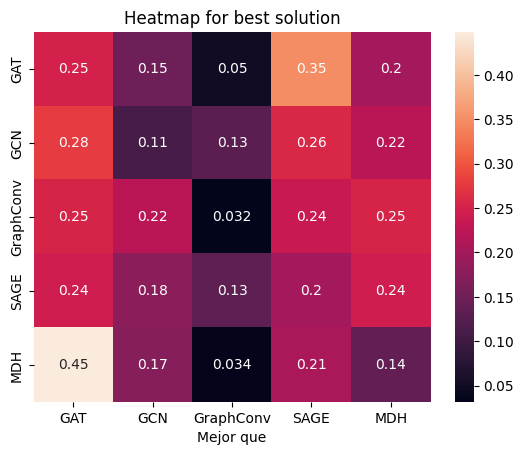

In [138]:
sns.heatmap(MT_, annot = True, xticklabels = models_name, yticklabels = models_name)
plt.title("Heatmap for best solution")
plt.xlabel("Mejor que");

## Por tiempo

In [45]:
MT = np.zeros((models_name.shape[0], models_name.shape[0]))
for graph in Full.graph.unique():
    Temp = np.array(Full.query(f"graph == '{graph}'").sort_values(by = "t_mean", ascending=False).model)
    for m in range(Temp.shape[0]):

        if (m + 1) == Temp.shape[0]:
            MT[ Dict[ Temp[m] ] ][ Dict[ Temp[m] ] ] += 1
            continue
        MT[ Dict[ Temp[m] ] ][ Dict[ Temp[m + 1] ] ] += 1

MT_ = MT / np.expand_dims(np.sum(MT, axis = 1), 1)
# La por filas siempre debe de dar 1 y para la probabilidad de estado estacionario, 
# se hace la transpuesta, es decir, las columnas son las deben sumar 1
MT_.sum(1)

array([1., 1., 1., 1., 1., 1.])

In [46]:
SPD_time = np.ones(MT_.shape[0])/MT_.shape[0] # initial distirbution
for _ in range(100):
    SPD_time = np.dot(MT_.T, SPD_time)
print(np.round(SPD_time,5), '\n',models_name)

[0.10134 0.02453 0.25904 0.44536 0.02289 0.14684] 
 ['GraphConv' 'GAT' 'MDH' 'GRAT' 'GCN' 'SAGE']


In [47]:
models_name[np.argsort(-SPD_time)]

array(['GRAT', 'MDH', 'SAGE', 'GraphConv', 'GAT', 'GCN'], dtype=object)

Text(0.5, 1.0, 'Heatmap for fastest solution')

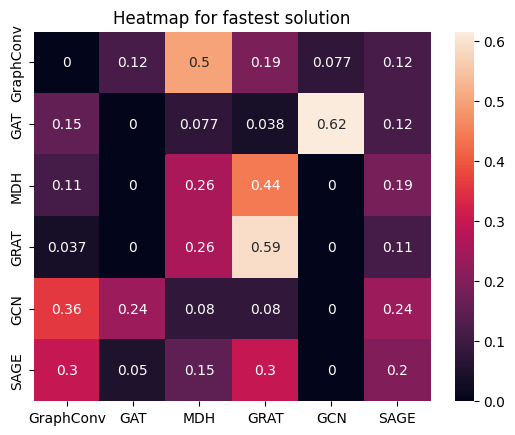

In [48]:
sns.heatmap(MT_, annot = True, xticklabels = models_name, yticklabels = models_name)
plt.title("Heatmap for fastest solution")

## All together

In [21]:
print("---- Best solution ----\n")
c = 1
for g in np.argsort(-SPD_best):
    print(c," - ", models_name[g][:6], f" \t {SPD_best[g]:.3f}")
    c += 1

---- Best solution ----

1  -  GAT  	 0.367
2  -  MDH  	 0.287
3  -  SAGE  	 0.214
4  -  GRAT  	 0.090
5  -  GCN  	 0.042
6  -  GraphC  	 0.000


In [50]:
print("------ Best time ------\n")
c = 1
for g in np.argsort(-SPD_time):
    print(c," - ", models_name[g][:6], f" \t {SPD_time[g]:.3f}")
    c+=1

------ Best time ------

1  -  GRAT  	 0.445
2  -  MDH  	 0.259
3  -  SAGE  	 0.147
4  -  GraphC  	 0.101
5  -  GAT  	 0.025
6  -  GCN  	 0.023


In [301]:
import numpy as np
x = np.array([[6.5,7], [5,3],[6,6],[7.5,8.2],[4,4], [6,7], [5,5], [5.1,5.2], [7,8], [8,8], [8,8]])
x = np.append(np.ones((11,1)),x, axis = 1)
y = np.array([6,8,7,2.5,4,10,5,7,4,12,4])

In [3]:
x

array([[1. , 6.5, 7. ],
       [1. , 5. , 3. ],
       [1. , 6. , 6. ],
       [1. , 7.5, 8.2],
       [1. , 4. , 4. ],
       [1. , 6. , 7. ],
       [1. , 5. , 5. ],
       [1. , 5.1, 5.2],
       [1. , 7. , 8. ],
       [1. , 8. , 8. ],
       [1. , 8. , 8. ]])

In [4]:
np.dot(x.T, x)

array([[ 11.  ,  68.1 ,  69.4 ],
       [ 68.1 , 439.51, 451.52],
       [ 69.4 , 451.52, 470.28]])

In [73]:
np.linalg.inv(np.dot(x.T, x))

array([[ 2.50477748, -0.61285329,  0.21877171],
       [-0.61285329,  0.31657017, -0.21350205],
       [ 0.21877171, -0.21350205,  0.1748271 ]])

In [74]:
np.dot(x.T,y)

array([ 69.5 , 432.45, 435.9 ])

In [5]:
B = np.dot(np.linalg.inv(np.dot(x.T, x)), np.dot(x.T,y))
B

array([ 4.41621859,  1.24192201, -0.91719443])

In [80]:
SST = np.dot(y,y) - (np.sum(y)**2)/11
SST

82.13636363636363

In [84]:
np.dot(B, np.dot(x.T,y))

444.19131364903933

In [81]:
SSE = np.dot(y,y) - np.dot(B, np.dot(x.T,y))
SSE

77.05868635096067

In [83]:
SSReg = SST - SSE
SSReg

5.077677285402956

In [90]:
np.dot(B, [1,10,10])

7.663494397900552

In [15]:
import torch
torch.sigmoid(torch.tensor([100]))

tensor([1.])